In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

wandb.init(project="neural_networks")
tensor_transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=tensor_transform)
test_dataset = datasets.FashionMNIST(root="./data", train=False, download=True, transform=tensor_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [5]:
code_artifact = wandb.Artifact("my_project", type="code")
code_artifact.add_file("my_project.ipynb")
wandb.log_artifact(code_artifact)

<Artifact my_project>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}")

cuda


In [7]:
class FashionMNISTClassifier(nn.Module):
    def __init__(self):
        super(FashionMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = FashionMNISTClassifier()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 91.14999999999999%


In [8]:
import matplotlib.pyplot as plt


class AE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(-1, 1, 28, 28)
        return decoded


model = AE()
model.to(device)
epochs = 5
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-8)
outputs = []
for epoch in range(epochs):
    running_loss = 0.0
    for image, _ in train_loader:
        image = image.cuda()
        optimizer.zero_grad()
        reconstructed = model(image)
        loss = criterion(reconstructed, image)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    outputs.append((epochs, image, reconstructed))
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}")
    wandb.log({"loss": running_loss})

correct = 0
total = 0
with torch.no_grad():
    for images, _ in test_loader:
        images = images.cuda()
        outputs = model(images)
        loss = criterion(outputs, images)

print(f"Final MSE Loss on test set: {loss.item():.4f}")

Epoch 1, Loss: 0.0911
Epoch 2, Loss: 0.0490
Epoch 3, Loss: 0.0419
Epoch 4, Loss: 0.0369
Epoch 5, Loss: 0.0342
Final MSE Loss on test set: 0.0438


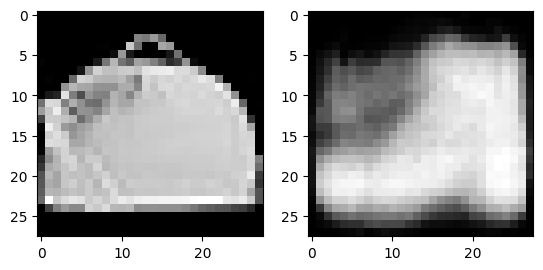

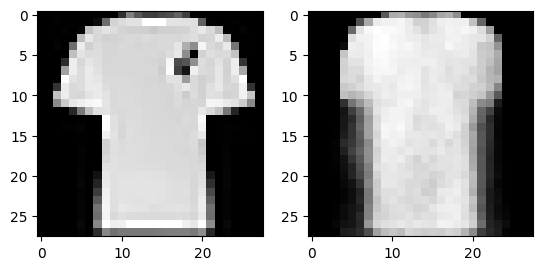

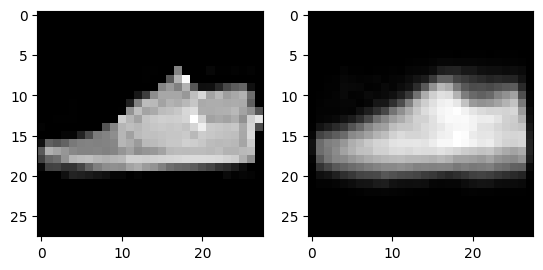

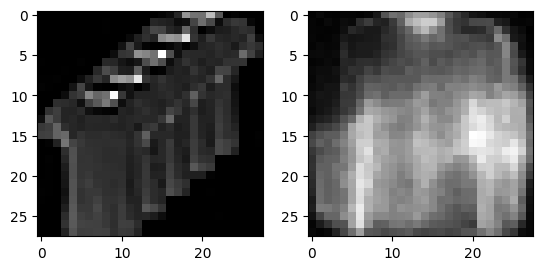

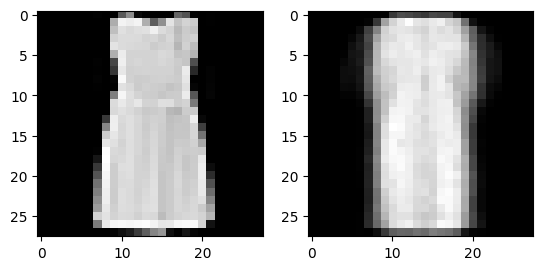

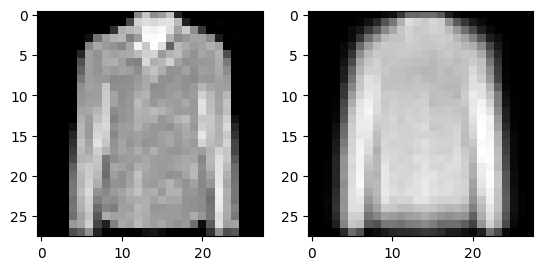

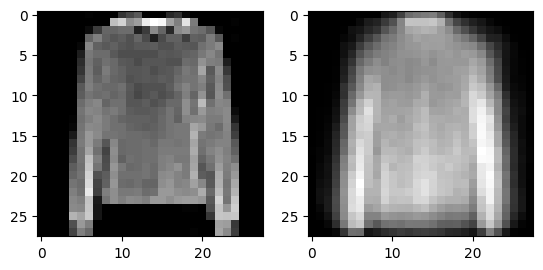

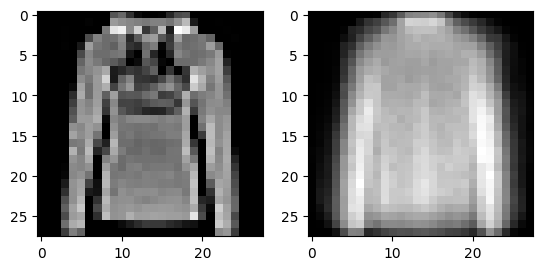

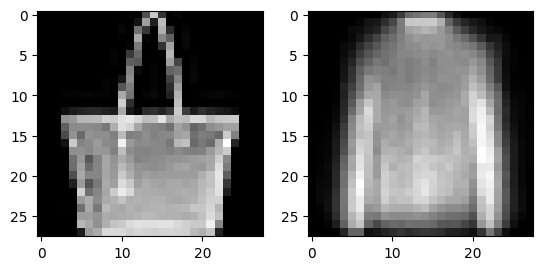

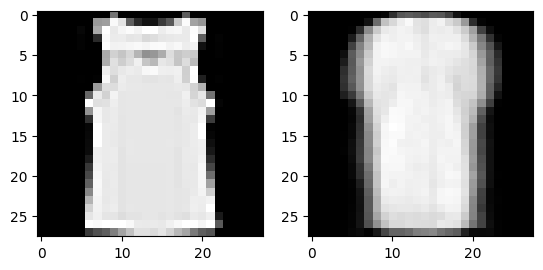

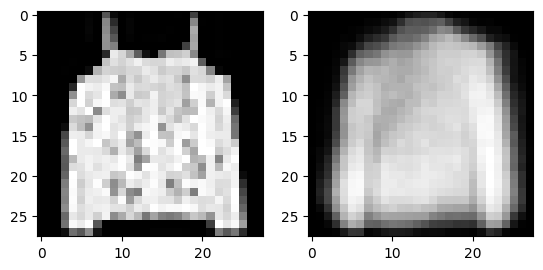

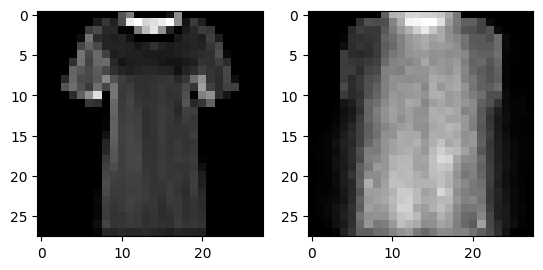

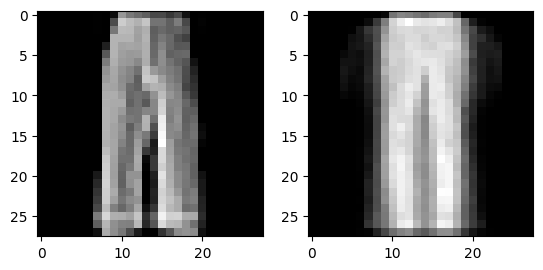

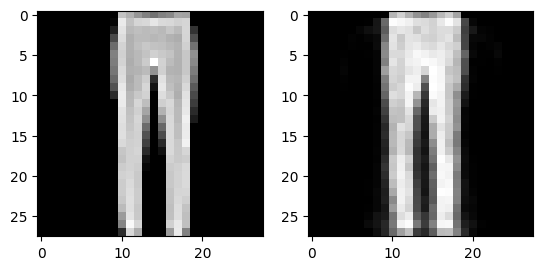

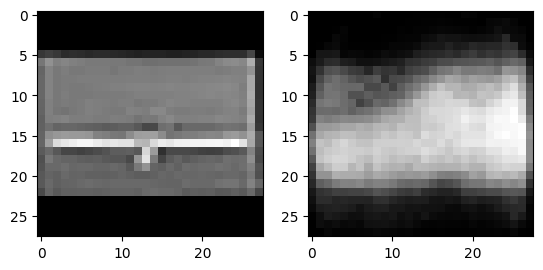

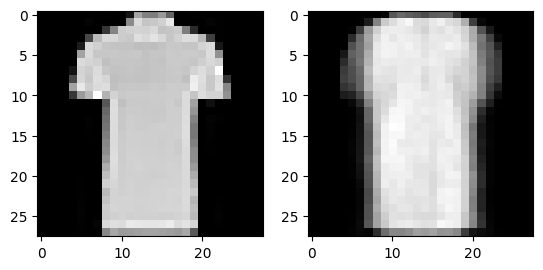

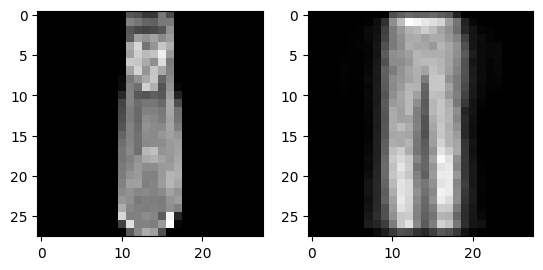

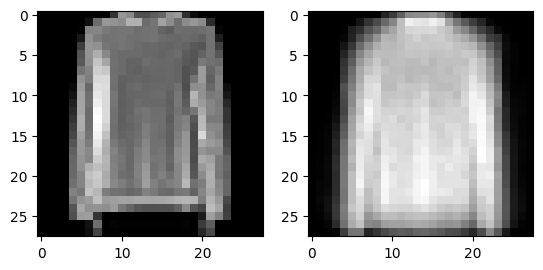

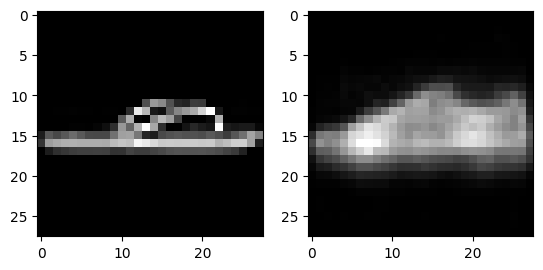

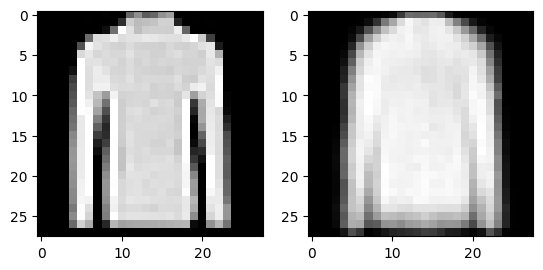

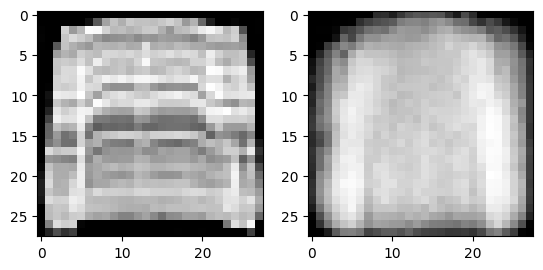

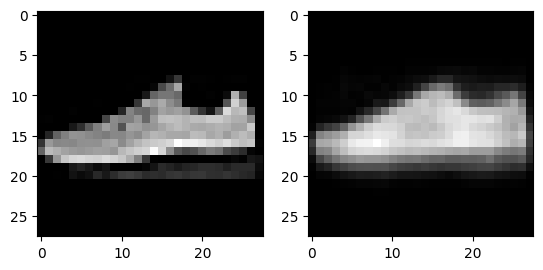

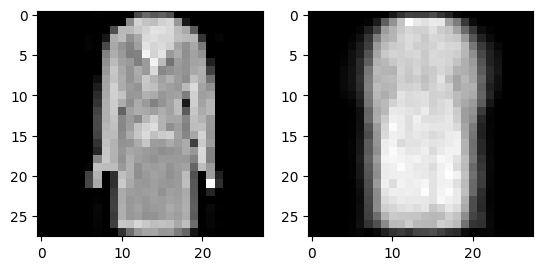

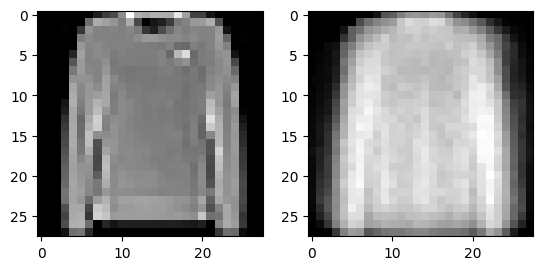

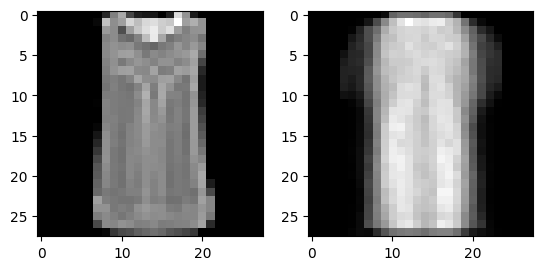

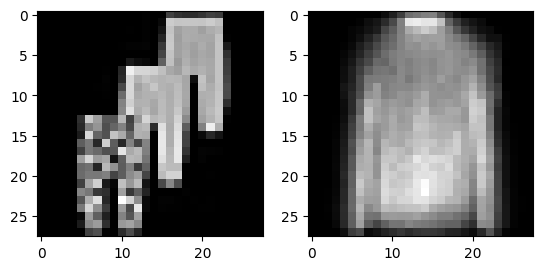

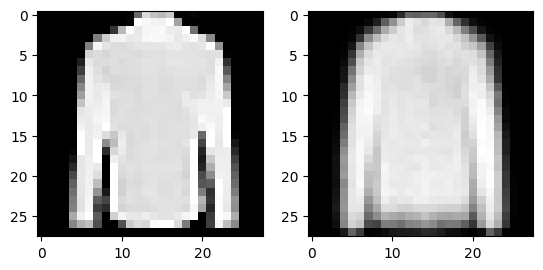

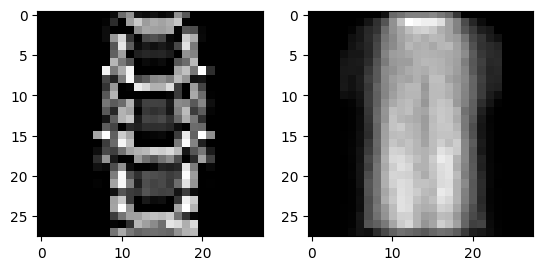

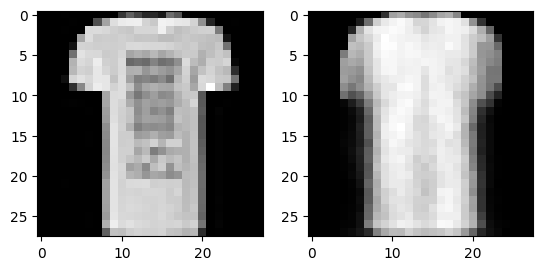

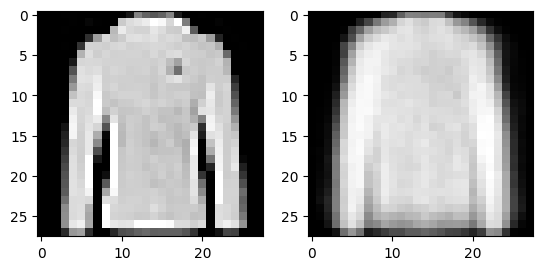

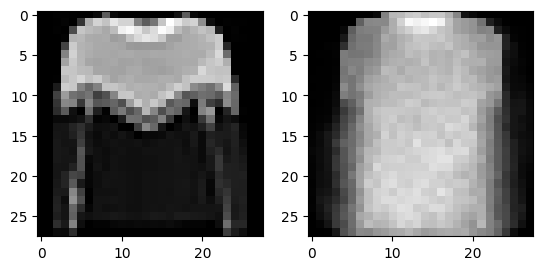

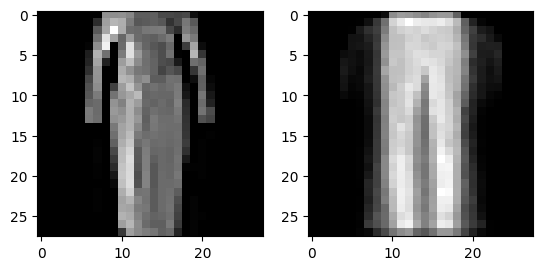

In [9]:
for img, recon in zip(image, reconstructed):
    img = img.cpu()
    recon = recon.cpu()
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.gray()
    plt.subplot(1, 2, 2)
    plt.imshow(recon[0].detach().numpy())
    plt.gray()
    plt.show()

In [10]:
wandb.finish()

loss,█▃▂▁▁
loss,32.12376
